# Custom Neural Network Implementation
This notebook implements a neural network from scratch with automatic differentiation.

## Setup and Imports

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from __future__ import annotations
import time

## Debug Configuration

In [35]:
DEBUG = False
SUPER_DEBUG = False

## Tensor Class
Core tensor class with automatic differentiation support.

In [37]:
class Tensor:
    # TODO: Only propogate gradients to Tensors with requires_gradient=True
    # TODO: store .grad as a Tensor s.t. we can compute higher order derivatives
    global_id = 0

    def __init__(self, data: np.array, requires_gradient: bool):
        # The raw Tensor data, stored as an n-dimensional nd.array
        self.data = data
        # The shape of the Tensor, i.e. the shape of the n-dimensional nd.array
        self.shape = data.shape
        """
        Boolean denoting whether we want to calculate the partial derivative
        of the overall function with respect to this Tensor
        e.g if we have input data Tensor, this is just data (not a parameter)
        so we dont need to calculate the tensors gradient
        """
        self.requires_gradient = requires_gradient
        # The Tensors used to produce this Tensor
        self._parents = []
        # The function that propogates this Tensor's
        # gradient to its parents
        self._backward = None
        self._backward_metadata = None
        # The gradient of the overall function
        # with respect to this Tensor
        self.grad = None
        # id used to identify the Tensor for debugging
        self._id = Tensor.global_id
        Tensor.global_id += 1

    def __str__(self):
        header = f"------ Tensor {self._id} ------\n"
        data = str(self.data) + "\n"
        shape = f"Shape: {self.shape}\n"
        footer = "-------------------------------"
        return header + data + shape + footer


    # Helper function to set the parents of this Tensor object
    # given its parent Tensors
    def set_parents(self, parents: list[Tensor]):
        self._parents = parents

    def backward(self):
        # To start the recursive process
        self.grad = np.ones_like(self.data)
        # Array to store the topological ordering of
        # Tensors in the computational graph
        topological_order = []
        """
        Set used in Post-Order DFS algorithm
        to store which nodes (Tensors) we have
        already visited
        """
        visited = set()

        # Post-Order DFS helper function
        def postOrderDFS(tensor: Tensor):
            # If the Tensor is None (at a leaf node)
            # or we have already visited this node
            # then return
            if tensor is None or tensor in visited:
                return

            # Otherwise visit the Tensor
            visited.add(tensor)

            # For every parent of this Tensor
            for parent_tensor in tensor._parents:
                # Run Post-Order DFS on it
                postOrderDFS(parent_tensor)

            # After running DFS on all parents, we have ensured that all
            # dependencies of this tensor (the nodes that it depends on)
            # appear earlier in the topological order.
            # So now we can safely add this tensor itself.
            topological_order.append(tensor)

        postOrderDFS(self)

        if DEBUG:
            print("Forward Topological Ordering (Parent -> Child):")
            for tensor in topological_order:
                print(tensor._id)

        for tensor in reversed(topological_order):
            if tensor._backward is not None:
                tensor._backward()

    def as_Tensor(x):
        if isinstance(x, Tensor):
            return x
        else:
            return Tensor(np.array(x), requires_gradient=False)

    def _reduce_grad_for_broadcast(child_grad: np.array, parent_shape: tuple,  child_shape: tuple):
        """
        child_grad: The gradient flowing into this parent from upstream
        parent_shape: The shape of the parent before broadcasting
        child_shape: The shape of the output child after broadcasing
        (if parent_shape != child_shape ==> broadcasing has occurred)
        """
        # parent_shape will always have smaller rank than child_shape
        # rank = # of indices required to identify an element
        rank_diff = len(child_shape) - len(parent_shape)
        parent_shape_padded = (1,) * rank_diff + parent_shape

        axes_to_sum = []
        # Anywhere parent_shape_padded == 1 and  child_shape != 1, a broadcast took place
        for i, (in_dim, out_dim) in enumerate(zip(parent_shape_padded, child_shape)):
            if in_dim == 1 and out_dim != 1:
                axes_to_sum.append(i)

        if axes_to_sum:
            child_grad = child_grad.sum(axis=tuple(axes_to_sum), keepdims=False)

        return child_grad.reshape(parent_shape)

    # Assuming we will only be working with 1D Tensors at the moment
    # i.e. only working with scalars until everything is working
    def __add__(self, other_parent: Tensor):
        # Make sure any input is a Tensor
        other_parent = Tensor.as_Tensor(other_parent)
        # Adding two numpy arrays together to produce another numpy array
        child_data = self.data + other_parent.data
        # If either parent of the output Tensor requires a gradient
        # Then this output Tensor will also require a gradient
        if self.requires_gradient or other_parent.requires_gradient:
            requires_gradient = True
        else:
            requires_gradient = False

        # The new child Tensor
        child = Tensor(child_data, requires_gradient=requires_gradient)

        # Setting the new child Tensor's parents
        parents = [self, other_parent]
        child.set_parents(parents)

        if DEBUG:
            print(f"Child: {child._id} produced from: {parents[0]._id} + {parents[1]._id}")

        # Setting the child Tensor's backward prop rule
        def _backward():
            if DEBUG:
                print(f"Propogating gradient from {child._id} to {[parent._id for parent in child._parents]} ")

            child_grad_self = Tensor._reduce_grad_for_broadcast(child_grad=child.grad,
                                                          parent_shape=self.shape,
                                                          child_shape=child.grad.shape)
            if self.grad is not None:
                self.grad += child_grad_self
            else:
                self.grad = child_grad_self

            child_grad_other = Tensor._reduce_grad_for_broadcast(child_grad=child.grad,
                                                          parent_shape=other_parent.shape,
                                                          child_shape=child.grad.shape)
            if other_parent.grad is not None:
                other_parent.grad += child_grad_other
            else:
                other_parent.grad = child_grad_other

            if SUPER_DEBUG:
                print(f"New parent gradients: {[p.grad for p in parents]}")

        child._backward = _backward

        return child


    def __sub__(self, other_parent: Tensor):
        # Make sure any input is a Tensor
        other_parent = Tensor.as_Tensor(other_parent)
        # Subtracting two numpy arrays together to produce another numpy array
        child_data = self.data - other_parent.data
        # If either parent of the output Tensor requires a gradient
        # Then this output Tensor will also require a gradient
        if self.requires_gradient or other_parent.requires_gradient:
            requires_gradient = True
        else:
            requires_gradient = False

        # The new child Tensor
        child = Tensor(child_data, requires_gradient=requires_gradient)

        # Setting the new child Tensor's parents
        parents = [self, other_parent]
        child.set_parents(parents)

        if DEBUG:
            print(f"Child: {child._id} produced from: {parents[0]._id} - {parents[1]._id}")

        # Setting the child Tensor's backward prop rule
        def _backward():
            if DEBUG:
                print(f"Propogating gradient from {child._id} to {[parent._id for parent in child._parents]} ")

            child_grad_self = Tensor._reduce_grad_for_broadcast(child_grad=child.grad,
                                                          parent_shape=self.shape,
                                                          child_shape=child.grad.shape)
            if self.grad is not None:
                self.grad += child_grad_self
            else:
                self.grad = child_grad_self

            child_grad_other = Tensor._reduce_grad_for_broadcast(child_grad=child.grad,
                                                          parent_shape=other_parent.shape,
                                                          child_shape=child.grad.shape)
            if other_parent.grad is not None:
                other_parent.grad -= child_grad_other
            else:
                other_parent.grad = -child_grad_other

            if SUPER_DEBUG:
                print(f"New parent gradients: {[p.grad for p in parents]}")

        child._backward = _backward

        return child


    def __mul__(self, other_parent: Tensor):
        # Make sure any input is a Tensor
        other_parent = Tensor.as_Tensor(other_parent)
        # Multiplying two numpy arrays together to produce another numpy array
        child_data = self.data * other_parent.data

        # If either parent of the output Tensor requires a gradient
        # Then this output Tensor will also require a gradient
        if self.requires_gradient or other_parent.requires_gradient:
            requires_gradient = True
        else:
            requires_gradient = False

        child = Tensor(child_data, requires_gradient=requires_gradient)

        # Setting the new child Tensor's parents
        parents = [self, other_parent]
        child.set_parents(parents)

        if DEBUG:
            print(f"Child: {child._id} produced from: {parents[0]._id} * {parents[1]._id}")

        # Setting the child Tensor's backward prop rule
        def _backward():
            if DEBUG:
                print(f"Propogating gradient from {child._id} to {[parent._id for parent in child._parents]} ")

            child_grad_self = Tensor._reduce_grad_for_broadcast(child_grad=child.grad,
                                                          parent_shape=self.shape,
                                                          child_shape=child.grad.shape)
            if self.grad is not None:
                self.grad += (other_parent.data) * child_grad_self
            else:
                self.grad = (other_parent.data) * child_grad_self

            child_grad_other = Tensor._reduce_grad_for_broadcast(child_grad=child.grad,
                                                          parent_shape=other_parent.shape,
                                                          child_shape=child.grad.shape)
            if other_parent.grad is not None:
                other_parent.grad += (self.data) * child_grad_other
            else:
                other_parent.grad = (self.data) * child_grad_other

            if SUPER_DEBUG:
                print(f"New parent gradients: {[p.grad for p in parents]}")

        child._backward = _backward

        return child

    def __matmul__(self, other_parent: Tensor):
        # Make sure any input is a Tensor
        other_parent = Tensor.as_Tensor(other_parent)
        # Mat Multiplying two numpy arrays together to produce another numpy array
        child_data = self.data @ other_parent.data

        # If either parent of the output Tensor requires a gradient
        # Then this output Tensor will also require a gradient
        if self.requires_gradient or other_parent.requires_gradient:
            requires_gradient = True
        else:
            requires_gradient = False

        child = Tensor(child_data, requires_gradient=requires_gradient)

        # Setting the new child Tensor's parents
        parents = [self, other_parent]
        child.set_parents(parents)

        if DEBUG:
            print(f"Child: {child._id} produced from: {parents[0]._id} @ {parents[1]._id}")

        # Setting the child Tensor's backward prop rule
        def _backward():
            if DEBUG:
                print(f"Propogating gradient from {child._id} to {[parent._id for parent in child._parents]} ")

            if self.grad is not None:
                self.grad += child.grad @ other_parent.data.T
            else:
                self.grad = child.grad @ other_parent.data.T

            if other_parent.grad is not None:
                other_parent.grad += self.data.T @ child.grad
            else:
                other_parent.grad = self.data.T @ child.grad

            if SUPER_DEBUG:
                print(f"New parent gradients: {[p.grad for p in parents]}")

        child._backward = _backward

        return child


    def __truediv__(self, other_parent: Tensor):
        # Make sure any input is a Tensor
        other_parent = Tensor.as_Tensor(other_parent)
        # Dividing two numpy arrays together to produce another numpy array
        child_data = self.data / other_parent.data

        # If either parent of the output Tensor requires a gradient
        # Then this output Tensor will also require a gradient
        if self.requires_gradient or other_parent.requires_gradient:
            requires_gradient = True
        else:
            requires_gradient = False

        child = Tensor(child_data, requires_gradient=requires_gradient)

        # Setting the new child Tensor's parents
        parents = [self, other_parent]
        child.set_parents(parents)

        if DEBUG:
            print(f"Child: {child._id} produced from: {parents[0]._id} / {parents[1]._id}")

        # Setting the child Tensor's backward prop rule
        def _backward():
            if DEBUG:
                print(f"Propogating gradient from {child._id} to {[parent._id for parent in child._parents]} ")

            child_grad_self = Tensor._reduce_grad_for_broadcast(child_grad=child.grad,
                                                          parent_shape=self.shape,
                                                          child_shape=child.grad.shape)
            if self.grad is not None:
                self.grad += child_grad_self / other_parent.data
            else:
                self.grad = child_grad_self / other_parent.data

            child_grad_other = Tensor._reduce_grad_for_broadcast(child_grad=child.grad,
                                                          parent_shape=other_parent.shape,
                                                          child_shape=child.grad.shape)
            if other_parent.grad is not None:
                other_parent.grad -= (child_grad_other * self.data) / (other_parent.data**2)
            else:
                other_parent.grad = -(child_grad_other * self.data) / (other_parent.data**2)

            if SUPER_DEBUG:
                print(f"New parent gradients: {[p.grad for p in parents]}")

        child._backward = _backward

        return child

    def __pow__(self, other_parent: Tensor):
        # Make sure any input is a Tensor
        other_parent = Tensor.as_Tensor(other_parent)
        # exponentiating one numpy array by the parent to produce another numpy array
        child_data = self.data ** other_parent.data

        # If either parent of the output Tensor requires a gradient
        # Then this output Tensor will also require a gradient
        if self.requires_gradient or other_parent.requires_gradient:
            requires_gradient = True
        else:
            requires_gradient = False

        child = Tensor(child_data, requires_gradient=requires_gradient)

        # Setting the new child Tensor's parents
        parents = [self, other_parent]
        child.set_parents(parents)

        if DEBUG:
            print(f"Child: {child._id} produced from: {parents[0]._id} ** {parents[1]._id}")

        # Setting the child Tensor's backward prop rule
        def _backward():
            if DEBUG:
                print(f"Propogating gradient from {child._id} to {[parent._id for parent in child._parents]} ")

            child_grad_self = Tensor._reduce_grad_for_broadcast(child_grad=child.grad,
                                                          parent_shape=self.shape,
                                                          child_shape=child.grad.shape)
            if self.grad is not None:
                self.grad += child_grad_self * other_parent.data * (self.data ** (other_parent.data -  1))
            else:
                self.grad = child_grad_self * other_parent.data * (self.data ** (other_parent.data -  1))

            child_grad_other = Tensor._reduce_grad_for_broadcast(child_grad=child.grad,
                                                          parent_shape=other_parent.shape,
                                                          child_shape=child.grad.shape)
            if other_parent.grad is not None:
                other_parent.grad += child_grad_other * (self.data ** other_parent.data) * np.log(self.data)
            else:
                other_parent.grad = child_grad_other * (self.data ** other_parent.data) * np.log(self.data)

            if SUPER_DEBUG:
                print(f"New parent gradients: {[p.grad for p in parents]}")

        child._backward = _backward

        return child


    def exp(parent: Tensor):
        # Make sure any input is a Tensor
        parent = Tensor.as_Tensor(parent)
        # The raw tensor data, exponentiated
        child_data = np.exp(parent.data)

        # If either parent of the output Tensor requires a gradient
        # Then this output Tensor will also require a gradient
        if parent.requires_gradient:
            requires_gradient = True
        else:
            requires_gradient = False

        child = Tensor(child_data, requires_gradient=requires_gradient)

        # Setting the new child Tensor's parent
        parents = [parent]
        child.set_parents(parents)

        if DEBUG:
            print(f"Child: {child._id} produced from: exp({parents[0]._id})")

        # Setting the child Tensor's backward prop rule
        def _backward():
            if DEBUG:
                print(f"Propogating gradient from {child._id} to {[parent._id for parent in child._parents]} ")

            if parent.grad is not None:
                parent.grad += (child.grad * np.exp(parent.data))
            else:
                parent.grad = (child.grad * np.exp(parent.data))

            if SUPER_DEBUG:
                print(f"New parent gradients: {[p.grad for p in parents]}")

        child._backward = _backward

        return child

    def sin(parent: Tensor):
        # Make sure any input is a Tensor
        parent = Tensor.as_Tensor(parent)
        # The raw tensor data, with sin applied
        child_data = np.sin(parent.data)

        # If parent of output requires gradient, child requires gradient
        if parent.requires_gradient:
            requires_gradient = True
        else:
            requires_gradient = False

        child = Tensor(child_data, requires_gradient=requires_gradient)

        # Setting the new child Tensor's parent
        parents = [parent]
        child.set_parents(parents)

        if DEBUG:
            print(f"Child: {child._id} produced from: sin({parents[0]._id})")

        # Setting the child Tensor's backward prop rule
        def _backward():
            if DEBUG:
                print(f"Propogating gradient from {child._id} to {[parent._id for parent in child._parents]} ")

            if parent.grad is not None:
                parent.grad += (child.grad * np.cos(parent.data))
            else:
                parent.grad = (child.grad * np.cos(parent.data))

            if SUPER_DEBUG:
                print(f"New parent gradients: {[p.grad for p in parents]}")

        child._backward = _backward

        return child

    def cos(parent: Tensor):
        # Make sure any input is a Tensor
        parent = Tensor.as_Tensor(parent)
        # The raw tensor data, with cos applied
        child_data = np.cos(parent.data)

        # If parent of output requires gradient, child requires gradient
        if parent.requires_gradient:
            requires_gradient = True
        else:
            requires_gradient = False

        child = Tensor(child_data, requires_gradient=requires_gradient)

        # Setting the new child Tensor's parent
        parents = [parent]
        child.set_parents(parents)

        if DEBUG:
            print(f"Child: {child._id} produced from: cos({parents[0]._id})")

        # Setting the child Tensor's backward prop rule
        def _backward():
            if DEBUG:
                print(f"Propogating gradient from {child._id} to {[parent._id for parent in child._parents]} ")

            if parent.grad is not None:
                parent.grad += (child.grad * -np.sin(parent.data))
            else:
                parent.grad = (child.grad * -np.sin(parent.data))

            if SUPER_DEBUG:
                print(f"New parent gradients: {[p.grad for p in parents]}")

        child._backward = _backward

        return child

    def sigmoid(parent: Tensor):
        # Make sure any input is a Tensor
        parent = Tensor.as_Tensor(parent)
        # The raw tensor data, with sigmoid applied
        child_data = 1 / (1 + np.exp(-parent.data))

        # If parent of output requires gradient, child requires gradient
        if parent.requires_gradient:
            requires_gradient = True
        else:
            requires_gradient = False

        child = Tensor(child_data, requires_gradient=requires_gradient)

        # Setting the new child Tensor's parent
        parents = [parent]
        child.set_parents(parents)

        if DEBUG:
            print(f"Child: {child._id} produced from: sigmoid({parents[0]._id})")

        # Setting the child Tensor's backward prop rule
        def _backward():
            if DEBUG:
                print(f"Propogating gradient from {child._id} to {[parent._id for parent in child._parents]} ")

            if parent.grad is not None:
                # Eventually look into caching this value during the forward pass
                parent.grad += child.grad * child.data * (1 - child.data)
            else:
                parent.grad = child.grad * child.data * (1 - child.data)

            if SUPER_DEBUG:
                print(f"New parent gradients: {[p.grad for p in parents]}")

        child._backward = _backward

        return child

    def ReLU(parent: Tensor):
        # Make sure any input is a Tensor
        parent = Tensor.as_Tensor(parent)
        # The raw tensor data, with ReLU applied
        child_data = np.maximum(0, parent.data)

        # If parent of output requires gradient, child requires gradient
        if parent.requires_gradient:
            requires_gradient = True
        else:
            requires_gradient = False

        child = Tensor(child_data, requires_gradient=requires_gradient)

        # Setting the new child Tensor's parent
        parents = [parent]
        child.set_parents(parents)

        if DEBUG:
            print(f"Child: {child._id} produced from: ReLU({parents[0]._id})")

        # Setting the child Tensor's backward prop rule
        def _backward():
            if DEBUG:
                print(f"Propogating gradient from {child._id} to {[parent._id for parent in child._parents]} ")

            grad_mask = (parent.data > 0).astype(float)
            if parent.grad is not None:
                parent.grad += child.grad * grad_mask
            else:
                parent.grad = child.grad * grad_mask

            if SUPER_DEBUG:
                print(f"New parent gradients: {[p.grad for p in parents]}")

        child._backward = _backward

        return child

    def transpose(self):
        # The raw tensor data, with cos applied
        child_data = self.data.T

        # If parent of output requires gradient, child requires gradient
        if self.requires_gradient:
            requires_gradient = True
        else:
            requires_gradient = False

        child = Tensor(child_data, requires_gradient=requires_gradient)

        # Setting the new child Tensor's parent
        parents = [self]
        child.set_parents(parents)

        if DEBUG:
            print(f"Child: {child._id} produced from: tranpose({parents[0]._id})")

        # Setting the child Tensor's backward prop rule
        def _backward():
            if DEBUG:
                print(f"Propogating gradient from {child._id} to {[parent._id for parent in child._parents]} ")

            if self.grad is not None:
                self.grad += child.grad.T
            else:
                self.grad = child.grad.T

            if SUPER_DEBUG:
                print(f"New parent gradients: {[p.grad for p in parents]}")

        child._backward = _backward

        return child

    def __getitem__(self, idx):
        # The raw tensor data, indexed at idx
        child_data = self.data[idx]

        # If parent of output requires gradient, child requires gradient
        if self.requires_gradient:
            requires_gradient = True
        else:
            requires_gradient = False

        child = Tensor(child_data, requires_gradient=requires_gradient)

        # Setting the new child Tensor's parent
        parents = [self]
        child.set_parents(parents)

        if DEBUG:
            print(f"Child: {child._id} produced from: {parents[0]._id}[{idx}]")

        # Setting the child Tensor's backward prop rule
        def _backward():
            if DEBUG:
                print(f"Propogating gradient from {child._id} to {[parent._id for parent in child._parents]} ")

            if self.grad is None:
                self.grad = np.zeros_like(self.data)

            self.grad[idx] += child.grad

            if SUPER_DEBUG:
                print(f"New parent gradients: {[p.grad for p in parents]}")

        child._backward = _backward

        return child

    def sum(self, axis: None | int | tuple):
        # Raw numpy data summed up
        child_data = self.data.sum(axis=axis)

        # If parent of output requires gradient, child requires gradient
        if self.requires_gradient:
            requires_gradient = True
        else:
            requires_gradient = False

        child = Tensor(child_data, requires_gradient=requires_gradient)

        # Setting the new child Tensor's parent
        parents = [self]
        child.set_parents(parents)

        if DEBUG:
            print(f"Child: {child._id} produced from: {parents[0]._id}.sum()")

        # Setting the child Tensor's backward prop rule
        def _backward():
            if DEBUG:
                print(f"Propogating gradient from {child._id} to {[parent._id for parent in child._parents]} ")

            if axis == None:
                if self.grad is not None:
                    self.grad += np.ones_like(self.data) * child.grad
                else:
                    self.grad = np.ones_like(self.data) * child.grad
            else:
                if isinstance(axis, int):
                    axis_tuple = (axis,)
                else:
                    axis_tuple = axis
                child_grad_reshaped = child.grad
                for axs in sorted(axis_tuple):
                    child_grad_reshaped = np.expand_dims(child_grad_reshaped, axis=axs)
                child_grad_broadcasted = np.broadcast_to(child_grad_reshaped, self.shape)

                if self.grad is not None:
                    self.grad += child_grad_broadcasted
                else:
                    self.grad = child_grad_broadcasted


            if SUPER_DEBUG:
                print(f"New parent gradients: {[p.grad for p in parents]}")

        child._backward = _backward

        return child

## Node Class

In [38]:
class Node:
    pass

## Layer Class

In [39]:
class Layer:
    global_id = 0
    def __init__(self, weights_tensor: Tensor, bias_tensor: Tensor, activation: callable):
        self.weights_tensor = weights_tensor
        self.bias_tensor = bias_tensor
        self.activation = activation
        self._id = Layer.global_id
        Layer.global_id += 1

## Neural Network Class

In [40]:
class NeuralNetwork:
    def __init__(self, layers: list[Layer] = None):
        self.layers = layers

    def forward(self, batch_input_tensor: Tensor):
        output_tensor = batch_input_tensor

        for layer in self.layers:
            output_tensor = output_tensor @ layer.weights_tensor
            output_tensor = output_tensor + layer.bias_tensor
            if layer.activation:
                output_tensor = layer.activation(output_tensor)
            if DEBUG:
                print(f"Layer {layer._id} output_tensor:")
                print(output_tensor)

        return output_tensor

## Helper Functions

In [41]:
def cost_fn(y_preds_tensor: Tensor, y_true_tensor: Tensor):
    num_elements = y_preds_tensor.shape[0]
    return ((y_preds_tensor - y_true_tensor) ** 2).sum(axis=None) / num_elements

def batches(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]

def plot_history(history, plot_title='', save_path=None):
    epochs = range(len(history["train_loss"]))
    plt.plot(epochs, history["train_loss"], color="blue", label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(plot_title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_data(x_test, y_test, y_preds):
    plt.scatter(x_test, y_test, color="blue", label="True Values")
    plt.scatter(x_test, y_preds, color="red", label="Predictions")
    plt.xlabel("X Value")
    plt.ylabel("Y Value")
    plt.legend()
    plt.grid(True)
    plt.show()

## Main Training Loop

## Dataset Options
- Below cell defines how data is read
- To change selection, go 2 cells down and change call to `set_data()`

In [42]:
# This is where data options are set:
import pandas as pd

def set_data(choice):
    global x_train, x_test, y_train, y_test  # ADD THIS LINE
    if choice == 1:
        X = np.linspace(0, 10, 100)
        X = X / 10
        y = np.sin(X)
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    if choice ==2:
        X = np.linspace(0, 10, 200)
        X = X / 10
        y = np.sin(5 * X) * np.exp(-X) + 0.5 * np.cos(10 * X)
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    if choice == 3:
        url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
        df = pd.read_csv(url)
        X = df.drop('medv', axis=1).values  # 13 features
        y = df['medv'].values  # target: median home value
        # Normalize features
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        y = (y - y.mean()) / y.std()
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if choice == 4:
        from sklearn.datasets import load_diabetes
        diabetes = load_diabetes()
        X = diabetes.data  # 10 features
        y = diabetes.target
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        y = (y - y.mean()) / y.std()
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if choice == 5:
        from sklearn.datasets import fetch_california_housing
        housing = fetch_california_housing()
        X = housing.data  # 8 features
        y = housing.target
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        y = (y - y.mean()) / y.std()
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [52]:
set_data(3)

print(f"Training set size: {x_train.shape}")
print(f"Test set size: {x_test.shape}")
print(f"Input features: {x_train.shape[1] if len(x_train.shape) > 1 else 1}")

Training set size: (404, 13)
Test set size: (102, 13)
Input features: 13


## Model Architecture Options
- Choose between a shallow or deep network

In [45]:
# Build initial model
# Determine input dimension from data
input_dim = x_train.shape[1] if len(x_train.shape) > 1 else 1
output_dim = 1

# OPTION 1: Shallow Network (2 layers) - Simpler, faster
# hidden_dim = 32
# print(f"Network architecture: {input_dim} -> {hidden_dim} (ReLU) -> {output_dim}")
#
# L0_weights = np.random.randn(input_dim, hidden_dim) * 0.1
# L0_bias = np.random.randn(hidden_dim) * 0.1
# L0_weights_tensor = Tensor(L0_weights, requires_gradient=True)
# L0_bias_tensor = Tensor(L0_bias, requires_gradient=True)
# L0 = Layer(weights_tensor=L0_weights_tensor, bias_tensor=L0_bias_tensor, activation=Tensor.ReLU)
#
# L1_weights = np.random.randn(hidden_dim, output_dim) * 0.1
# L1_bias = np.random.randn(output_dim) * 0.1
# L1_weights_tensor = Tensor(L1_weights, requires_gradient=True)
# L1_bias_tensor = Tensor(L1_bias, requires_gradient=True)
# L1 = Layer(weights_tensor=L1_weights_tensor, bias_tensor=L1_bias_tensor, activation=None)
#
# network = NeuralNetwork([L0, L1])

# OPTION 2: Deeper Network (4 layers) - More expressive, better for complex datasets
hidden_dims = [64, 32, 16]  # 3 hidden layers with decreasing size
print(f"Network architecture: {input_dim} -> {hidden_dims[0]} (ReLU) -> {hidden_dims[1]} (ReLU) -> {hidden_dims[2]} (ReLU) -> {output_dim}")

layers = []

# Layer 0: Input -> First Hidden
L0_weights = np.random.randn(input_dim, hidden_dims[0]) * np.sqrt(2.0 / input_dim)  # He initialization
L0_bias = np.zeros(hidden_dims[0])
L0_weights_tensor = Tensor(L0_weights, requires_gradient=True)
L0_bias_tensor = Tensor(L0_bias, requires_gradient=True)
L0 = Layer(weights_tensor=L0_weights_tensor, bias_tensor=L0_bias_tensor, activation=Tensor.ReLU)
layers.append(L0)

# Layer 1: First Hidden -> Second Hidden
L1_weights = np.random.randn(hidden_dims[0], hidden_dims[1]) * np.sqrt(2.0 / hidden_dims[0])
L1_bias = np.zeros(hidden_dims[1])
L1_weights_tensor = Tensor(L1_weights, requires_gradient=True)
L1_bias_tensor = Tensor(L1_bias, requires_gradient=True)
L1 = Layer(weights_tensor=L1_weights_tensor, bias_tensor=L1_bias_tensor, activation=Tensor.ReLU)
layers.append(L1)

# Layer 2: Second Hidden -> Third Hidden
L2_weights = np.random.randn(hidden_dims[1], hidden_dims[2]) * np.sqrt(2.0 / hidden_dims[1])
L2_bias = np.zeros(hidden_dims[2])
L2_weights_tensor = Tensor(L2_weights, requires_gradient=True)
L2_bias_tensor = Tensor(L2_bias, requires_gradient=True)
L2 = Layer(weights_tensor=L2_weights_tensor, bias_tensor=L2_bias_tensor, activation=Tensor.ReLU)
layers.append(L2)

# Layer 3: Third Hidden -> Output
L3_weights = np.random.randn(hidden_dims[2], output_dim) * np.sqrt(2.0 / hidden_dims[2])
L3_bias = np.zeros(output_dim)
L3_weights_tensor = Tensor(L3_weights, requires_gradient=True)
L3_bias_tensor = Tensor(L3_bias, requires_gradient=True)
L3 = Layer(weights_tensor=L3_weights_tensor, bias_tensor=L3_bias_tensor, activation=None)
layers.append(L3)

network = NeuralNetwork(layers)

Network architecture: 10 -> 64 (ReLU) -> 32 (ReLU) -> 16 (ReLU) -> 1


In [46]:
# Training hyperparameters
num_epochs = 1000
batch_size = 16
learning_rate = 0.01

history = {"train_loss": []}

In [47]:
# Run gradient descent
start_time = time.time()
for epoch in range(num_epochs):
    # For each batch
    epoch_avg_loss = 0
    batch_counter = 0

    for x_batch, y_batch in batches(x_train, y_train, batch_size):
        # Ensure x_batch has shape (batch_size, input_dim)
        if len(x_batch.shape) == 1:
            x_batch = x_batch.reshape(-1, 1)

        # Cast to Tensor
        x_batch_tensor = Tensor(x_batch, requires_gradient=False)

        # y_batch has shape(batch_size,)
        # need to reshape to (batch_size, 1)
        y_batch = y_batch.reshape(-1, 1)
        # Cast to Tensor
        y_batch_tensor = Tensor(y_batch, requires_gradient=False)

        # Perform forward pass to create computational graph
        batch_output_tensor = network.forward(x_batch_tensor)

        # Calculate cost
        batch_loss = cost_fn(batch_output_tensor, y_batch_tensor)
        batch_counter += 1
        epoch_avg_loss += batch_loss.data

        # Perform backward pass
        batch_loss.backward()

        # Take GD step
        for layer in network.layers:
            layer.weights_tensor.data -= learning_rate * layer.weights_tensor.grad
            layer.bias_tensor.data    -= learning_rate * layer.bias_tensor.grad

        # Zero gradients
        for layer in network.layers:
            layer.weights_tensor.grad = np.zeros_like(layer.weights_tensor.data)
            layer.bias_tensor.grad = np.zeros_like(layer.bias_tensor.data)

    epoch_avg_loss /= batch_counter
    history["train_loss"].append(epoch_avg_loss)

    # Print progress every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_avg_loss:.6f}")

end_time = time.time()
total = end_time - start_time
print("Train Time: " , total)

/var/folders/1g/y6jd6zhs0wq426c5ls9mx5zr0000gn/T/ipykernel_76878/883712328.py:409: RuntimeWarning: invalid value encountered in log
  other_parent.grad = child_grad_other * (self.data ** other_parent.data) * np.log(self.data)


Epoch 100/1000, Loss: 0.200362
Epoch 200/1000, Loss: 0.032844
Epoch 300/1000, Loss: 0.007553
Epoch 400/1000, Loss: 0.005840
Epoch 500/1000, Loss: 0.001454
Epoch 600/1000, Loss: 0.000749
Epoch 700/1000, Loss: 0.000484
Epoch 800/1000, Loss: 0.000424
Epoch 900/1000, Loss: 0.000728
Epoch 1000/1000, Loss: 0.000227
Train Time:  3.164945125579834


## Evaluation and Visualization

In [48]:
# Run inference on test data
# Ensure proper shape
if len(x_test.shape) == 1:
    x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Cast x_test, y_test to Tensors
x_test_tensor = Tensor(x_test, requires_gradient=False)
y_test_tensor = Tensor(y_test, requires_gradient=False)
y_preds_tensor = network.forward(x_test_tensor)
test_loss_tensor = cost_fn(y_preds_tensor, y_test_tensor)

print(f"Loss on Test Data: {test_loss_tensor.data:.6f}")

Loss on Test Data: 0.904131


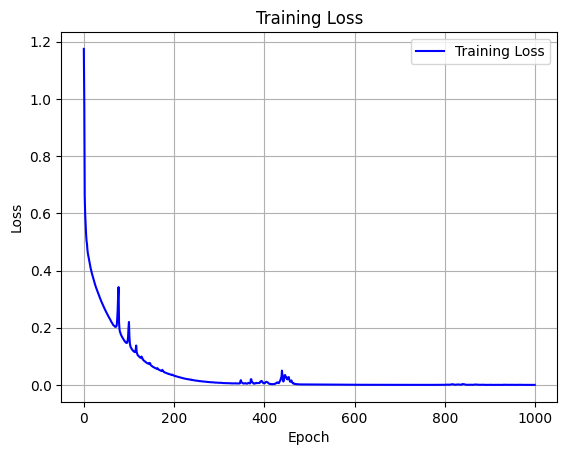

In [49]:
# Plot training history
plot_history(history, "Training Loss")

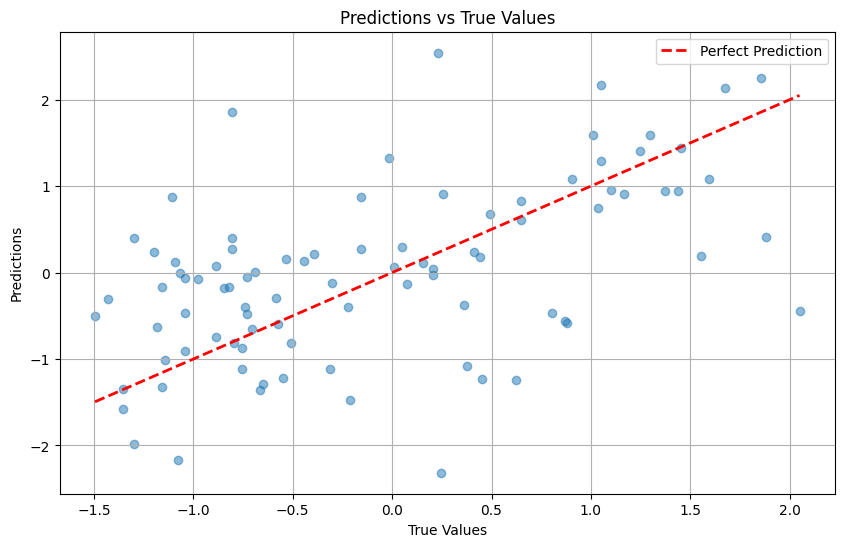

In [50]:
# Plot predictions vs true values
# For multi-dimensional input, we'll plot predictions vs true values directly
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tensor.data, y_preds_tensor.data, alpha=0.5)
plt.plot([y_test_tensor.data.min(), y_test_tensor.data.max()],
         [y_test_tensor.data.min(), y_test_tensor.data.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()


PYTORCH COMPARISON

Architecture: 10 -> 64 -> 32 -> 16 -> 1

Training PyTorch model...
Epoch 100/1000, Loss: 0.118795
Epoch 200/1000, Loss: 0.040523
Epoch 300/1000, Loss: 0.017086
Epoch 400/1000, Loss: 0.010104
Epoch 500/1000, Loss: 0.007460
Epoch 600/1000, Loss: 0.006936
Epoch 700/1000, Loss: 0.002770
Epoch 800/1000, Loss: 0.020529
Epoch 900/1000, Loss: 0.000642
Epoch 1000/1000, Loss: 0.000379

RESULTS

Custom Autograd Test Loss: 0.904131
PyTorch Test Loss:         1.008189
Difference:                0.104058


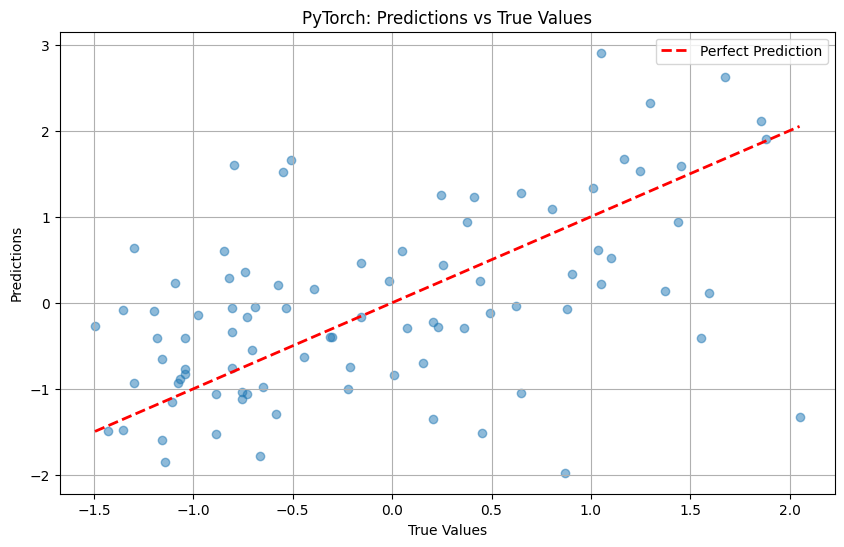

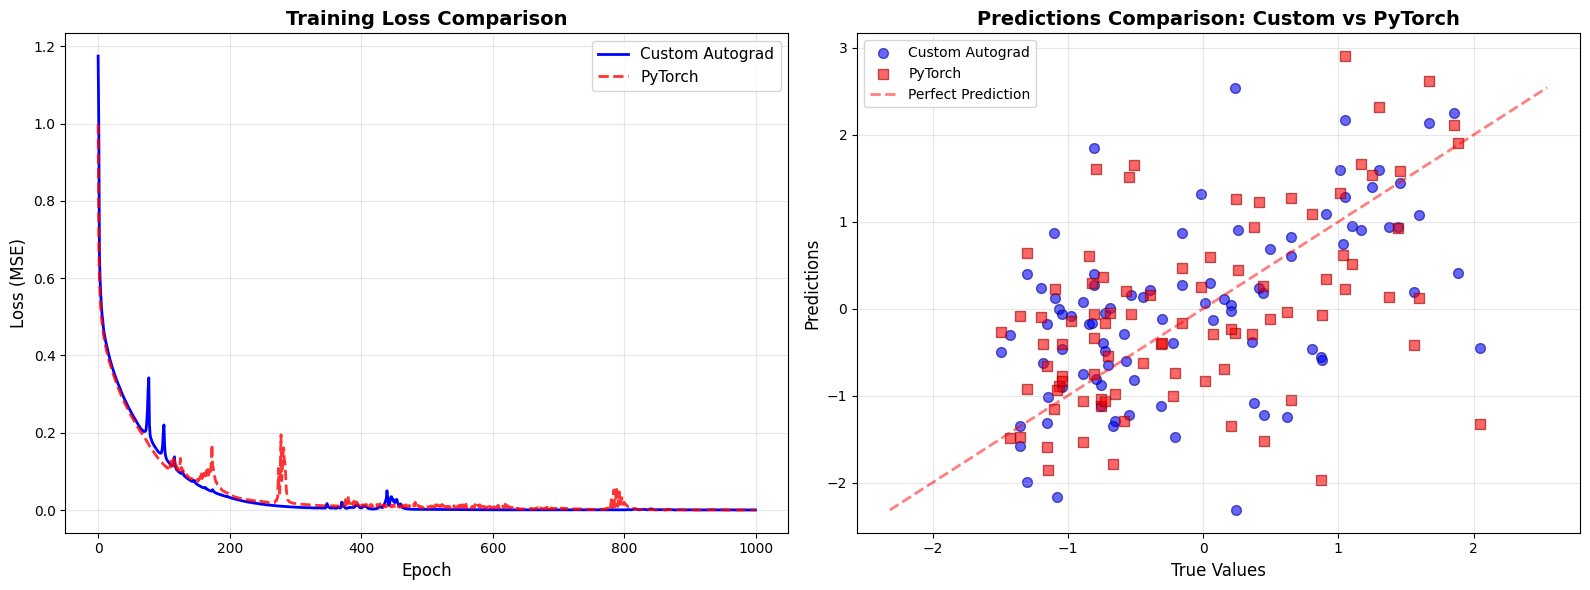


SUMMARY STATISTICS

Custom Autograd - Mean Absolute Error: 0.715670
PyTorch - Mean Absolute Error:         0.762765

Custom Autograd - Max Error: 2.659636
PyTorch - Max Error:         3.377121
PT runtime: 5.187057018280029
Custom runtime: 3.164945125579834


In [51]:
# PyTorch Comparison - Clean Implementation
import torch
import torch.nn as nn
import torch.optim as optim

print("\n" + "="*60)
print("PYTORCH COMPARISON")
print("="*60)

# Convert data to PyTorch tensors with correct shapes
X_train_torch = torch.FloatTensor(x_train)
y_train_torch = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_torch = torch.FloatTensor(x_test)
y_test_torch = torch.FloatTensor(y_test).reshape(-1, 1)

# Define equivalent PyTorch architecture
class PyTorchNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(PyTorchNet, self).__init__()

        self.layers = nn.ModuleList()

        # First layer: input -> first hidden
        self.layers.append(nn.Linear(input_dim, hidden_dims[0]))

        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))

        # Output layer
        self.layers.append(nn.Linear(hidden_dims[-1], output_dim))

        # Initialize weights with He initialization (matches custom implementation)
        for layer in self.layers:
            nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        # Apply ReLU to all hidden layers
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        # No activation on output layer
        x = self.layers[-1](x)
        return x

# Create model with same architecture
input_dim = X_train_torch.shape[1] if len(X_train_torch.shape) > 1 else 1
hidden_dims = [64, 32, 16]
output_dim = 1

print(f"\nArchitecture: {input_dim} -> {' -> '.join(map(str, hidden_dims))} -> {output_dim}")

pytorch_model = PyTorchNet(input_dim, hidden_dims, output_dim)

# Use same hyperparameters as custom implementation
criterion = nn.MSELoss()
optimizer = optim.SGD(pytorch_model.parameters(), lr=0.01)

# Training loop
pytorch_history = {"train_loss": []}
num_epochs = 1000
batch_size = 16

print(f"\nTraining PyTorch model...")
pytorch_model.train()

pt_start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0

    # Mini-batch gradient descent
    for i in range(0, len(X_train_torch), batch_size):
        batch_X = X_train_torch[i:i+batch_size]
        batch_y = y_train_torch[i:i+batch_size]

        # Forward pass
        predictions = pytorch_model(batch_X)
        loss = criterion(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    pytorch_history["train_loss"].append(avg_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.6f}")

pt_end_time = time.time()

pt_total_time = pt_end_time - pt_start_time
# Evaluation
print("\n" + "="*60)
print("RESULTS")
print("="*60)

pytorch_model.eval()
with torch.no_grad():
    pytorch_predictions = pytorch_model(X_test_torch)
    pytorch_test_loss = criterion(pytorch_predictions, y_test_torch)

print(f"\nCustom Autograd Test Loss: {test_loss_tensor.data:.6f}")
print(f"PyTorch Test Loss:         {pytorch_test_loss.item():.6f}")
print(f"Difference:                {abs(test_loss_tensor.data - pytorch_test_loss.item()):.6f}")

# Plot 1: PyTorch predictions only (matching your style)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_torch.numpy(), pytorch_predictions.numpy(), alpha=0.5)
plt.plot([y_test_torch.numpy().min(), y_test_torch.numpy().max()],
         [y_test_torch.numpy().min(), y_test_torch.numpy().max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('PyTorch: Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Comparison between Custom Autograd and PyTorch
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Training loss comparison
axes[0].plot(history["train_loss"], label='Custom Autograd',
             color='blue', linewidth=2)
axes[0].plot(pytorch_history["train_loss"], label='PyTorch',
             color='red', linewidth=2, linestyle='--', alpha=0.8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Predictions comparison
axes[1].scatter(y_test_torch.numpy(), y_preds_tensor.data,
                alpha=0.6, s=50, label='Custom Autograd', color='blue', edgecolors='navy')
axes[1].scatter(y_test_torch.numpy(), pytorch_predictions.numpy(),
                alpha=0.6, s=50, label='PyTorch', color='red',
                marker='s', edgecolors='darkred')

# Perfect prediction line
min_val = min(y_test_torch.numpy().min(), y_preds_tensor.data.min())
max_val = max(y_test_torch.numpy().max(), y_preds_tensor.data.max())
axes[1].plot([min_val, max_val], [min_val, max_val],
             'r--', linewidth=2, label='Perfect Prediction', alpha=0.5)

axes[1].set_xlabel('True Values', fontsize=12)
axes[1].set_ylabel('Predictions', fontsize=12)
axes[1].set_title('Predictions Comparison: Custom vs PyTorch', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

custom_pred_error = np.abs(y_preds_tensor.data.flatten() - y_test.flatten())
pytorch_pred_error = np.abs(pytorch_predictions.numpy().flatten() - y_test.flatten())

print(f"\nCustom Autograd - Mean Absolute Error: {custom_pred_error.mean():.6f}")
print(f"PyTorch - Mean Absolute Error:         {pytorch_pred_error.mean():.6f}")
print(f"\nCustom Autograd - Max Error: {custom_pred_error.max():.6f}")
print(f"PyTorch - Max Error:         {pytorch_pred_error.max():.6f}")

print("PT runtime:", pt_total_time)
print("Custom runtime:", total)